# Signal processing in BCI - BABIH VELAZQUEZ DE BURNAY

In [70]:
import numpy as np
import pandas as pd
from mne.io import RawArray
from mne.channels import read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs
from mne.viz.topomap import _prepare_topo_plot, plot_topomap
from mne.decoding import CSP
from glob import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.signal import welch
from mne import pick_types
import mne
from mne.viz.topomap import _prepare_topo_plot, plot_topomap

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

import cycler
import itertools

import warnings
warnings.filterwarnings("ignore")


## Dataset

EEG signals from a motor task with 6 detected events. Description of the dataset:

This data contains EEG recordings of subjects performing grasp-and-lift (GAL) trials. The following video shows an example of a trial:

https://www.youtube.com/watch?v=y3_Izuop2gY

A detailed account of the data can be found in 

Luciw MD, Jarocka E, Edin BB (2014) Multi-channel EEG recordings during 3,936 grasp and lift trials with varying weight and friction. Scientific Data 1:140047. www.nature.com/articles/sdata201447

There are 12 subjects in total, 10 series of trials for each subject, and approximately 30 trials within each series. The number of trials varies for each series. The training set contains the first 8 series for each subject. The test set contains the 9th and 10th series.

For each GAL, you are tasked to detect 6 events:

    HandStart
    FirstDigitTouch
    BothStartLoadPhase
    LiftOff
    Replace
    BothReleased

These events always occur in the same order. In the training set, there are two files for each subject + series combination:

    the *_data.csv files contain the raw 32 channels EEG data (sampling rate 500Hz)
    the *_events.csv files contains the ground truth frame-wise labels for all events

The events files for the test set are not provided and must be predicted. Each timeframe is given a unique id column according to the subject, series, and frame to which it belongs. The six label columns are either zero or one, depending on whether the corresponding event has occurred within ±150ms (±75frames). A perfect submission will predict a probability of one for this entire window.




EEG data is saved in csv files. There is an individual file for each serie, containing 30 trials of the Grasp and Lift task. 

*Note that there are other formats that are specific for temporal series in biomedicine. MNE has utilities to load data from the most common of these formats. Some examples are  European Data Format (EDF), General Data Format (GDF) or the EEGLAB format (a Matlab toolbox)

## Reading the data

### Pandas introduction

Pandas is a Python package with useful tools for data reading, analysis and writing.

We will explore how to read the EEG data and events from the dataset

First, for convenience, we will define the file names for custom subject and series

In [3]:

subject=1
serie=5
fname = './train/subj%d_series%d_data.csv' % (subject,serie)
f_events = fname.replace('_data', '_events')

print (fname)
print (f_events)


./train/subj1_series5_data.csv
./train/subj1_series5_events.csv


Use Pandas to read the CSV files

In [4]:
data = pd.read_csv(fname)
events = pd.read_csv(f_events)

We can use the resulting Pandas objects to explore the data. For example, we can print the headers

In [5]:
# Information about the columns
data.info()
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210644 entries, 0 to 210643
Data columns (total 33 columns):
id      210644 non-null object
Fp1     210644 non-null int64
Fp2     210644 non-null int64
F7      210644 non-null int64
F3      210644 non-null int64
Fz      210644 non-null int64
F4      210644 non-null int64
F8      210644 non-null int64
FC5     210644 non-null int64
FC1     210644 non-null int64
FC2     210644 non-null int64
FC6     210644 non-null int64
T7      210644 non-null int64
C3      210644 non-null int64
Cz      210644 non-null int64
C4      210644 non-null int64
T8      210644 non-null int64
TP9     210644 non-null int64
CP5     210644 non-null int64
CP1     210644 non-null int64
CP2     210644 non-null int64
CP6     210644 non-null int64
TP10    210644 non-null int64
P7      210644 non-null int64
P3      210644 non-null int64
Pz      210644 non-null int64
P4      210644 non-null int64
P8      210644 non-null int64
PO9     210644 non-null int64
O1      210644 non

In [10]:
# Checking if the data has been loaded correctly
data.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series5_0,65,164,278,74,-143,449,-196,298,-3,...,201,93,231,403,476,-199,76,171,84,70
1,subj1_series5_1,55,-82,222,129,-152,493,-235,263,10,...,224,86,231,412,481,-140,74,174,123,95
2,subj1_series5_2,13,-207,189,88,-134,539,-200,297,7,...,193,70,239,401,419,-59,98,180,66,-28
3,subj1_series5_3,-39,-98,166,84,-161,463,-253,263,-24,...,135,46,233,410,447,-99,81,193,107,90
4,subj1_series5_4,21,54,255,142,-141,385,-191,269,-40,...,99,31,262,418,449,-219,47,187,115,124


Furthermore, we can plot a section of the data/events.

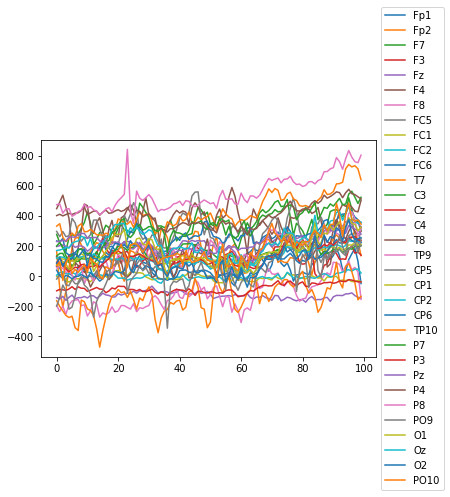

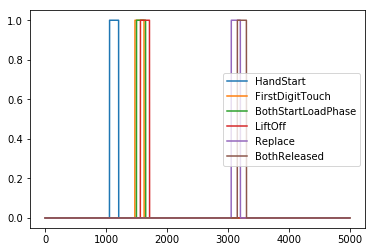

In [11]:
# The data
data[0:100].plot()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# The events
events[0:5000].plot()
plt.show()

### Reading data in MNE format

Now, we will use the MNE package for exploring and visualizing the data.

As MNE has no specific function for loading from a CSV file, we use the next custom function. which reads the file and creates a MNE Raw object.


In [12]:
# Custom function for loading data from csv to MNE
def create_mne_raw_object_from_csv(fname):
    f_events = fname.replace('_data','_events')
    
    # read EEG file (csv) using Pandas
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    montage = read_montage('standard_1005',ch_names)

    # read event file
    events = pd.read_csv(f_events)
    events_names = events.columns[1:]
    events_data = np.array(events[events_names]).T
    
    # concatenate event file and data
    data = np.concatenate((1e-6*np.array(data[ch_names]).T,events_data))        
    
    # define channel type, the first is EEG, the last 6 are stimulations
    ch_type = ['eeg']*len(ch_names) + ['stim']*6
    
    # create and populate MNE info structure
    ch_names.extend(events_names)
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
    
    # create raw object 
    raw = RawArray(data,info,verbose=False)
    return raw

## Exploring the MNE Raw data structure

### Basic information

In [29]:
# import the data and check the info: channel names, etc.

raw = create_mne_raw_object_from_csv(fname)
print(raw.info)
print(raw.info['ch_names'])

1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
<Info | 17 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, ...
    chs : list | 38 items (EEG: 32, STIM: 6)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 35 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    nchan : int | 38
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 500.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_date : NoneType
    me

### Basic representations of electrodes and signals

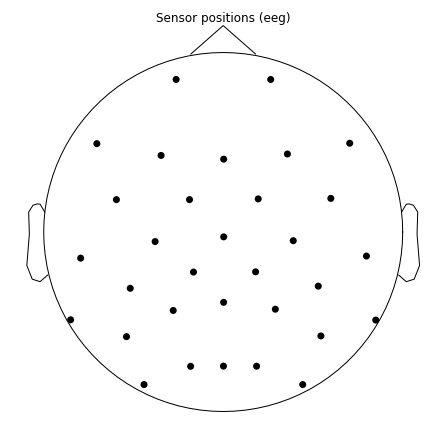

In [19]:
# electrodes localization in the scalp
raw.plot_sensors();

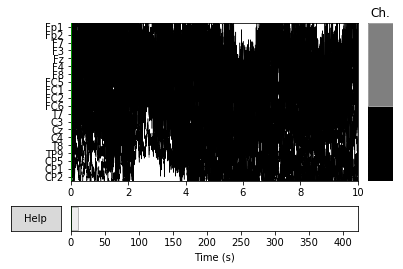

In [18]:
# visualization of the signals, including both EEG electrodes and events signals. 
#This is a noisy plot because data is still unfiltered
raw.plot();

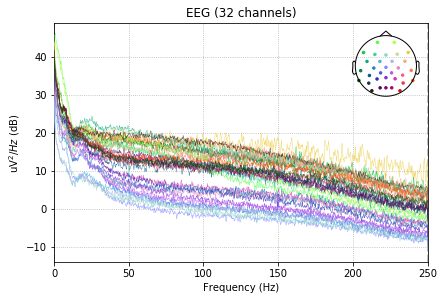

In [21]:

# visualization of the Power Spectral Density (PSD). 
# This computes and plots the distribution of power in function of the frequency
raw.plot_psd();

## Evoked potentials and data segmentation (epochs)


Subjects initiate the grasp and lift task when they observe a led turning on. This external stimulus will produce a trigger for a posible Evoked Potential (EP) that should be reflected in a temporal analysis of the EEG signals.

For this analysis, signals can be segmented in small epochs around the event of interest. The HandStart event, which indicates when the hand starts moving can be used as an approximation to the time when the subject receives the external stimulus. 



First, we try to visualize the raw data.

28 events found
Event IDs: [1]
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


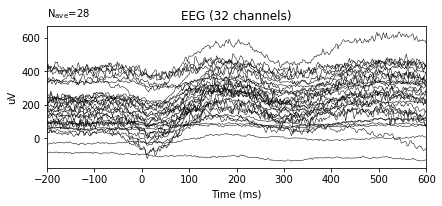

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


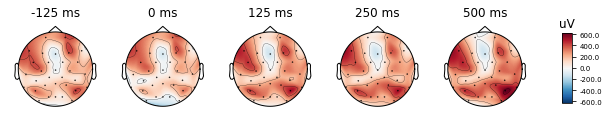

''

In [31]:
# the event of interest can be extracted from the raw object, which also contains the stimulus channels.
events = find_events(raw,stim_channel='HandStart')
# epochs are automatically built from every HandStart event. 
# Epochs length and precise position is controled with a time offset (tmin and tmax)
epochs = Epochs(raw, events, {'HandStart' : 1}, tmin=-0.2, tmax=0.6, proj=False,
                baseline=None, preload=True, verbose =False)
                
# It is possible to compute the average epoch for each EEG, which facilitates the analysis
# and increases the signal to noise ratio
avg_epochs = epochs.average()
avg_epochs.plot()

# An a topographic map can be plot for any chosen time within the epoch
avg_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])
;

### Filtering signals

Now, we will filter the signals before the visualization

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


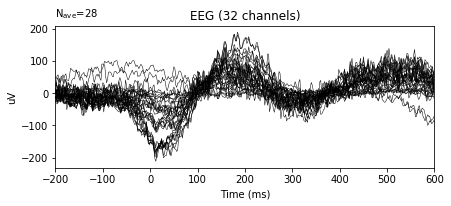

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


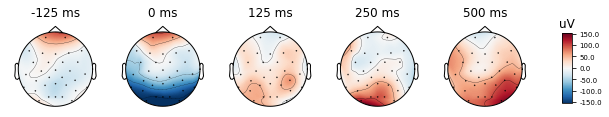

''

In [32]:
# The method filter() allows different kinds of filters to be applied, varying the l_freq and h_freq arguments.
# l_freq and h_freq are the frequencies below which and above which, respectively, to filter out of the data. 
# Thus the uses are:
#        l_freq < h_freq: band-pass filter
#        l_freq > h_freq: band-stop filter
#        l_freq is not None and h_freq is None: high-pass filter
#        l_freq is None and h_freq is not None: low-pass filter


hp_raw = raw.copy().filter(l_freq=1,h_freq=None)
hp_epochs = Epochs(hp_raw, events, {'HandStart' : 1}, tmin=-0.2, tmax=0.6, proj=False,
                baseline=None, preload=True, 
                verbose =False)

# Visualize the result
avg_epochs = hp_epochs.average()
avg_epochs.plot()
avg_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])
;

A) We apply a low-pass and a band-pass filter to the signals and plot the power spectral density (PSD) for both of them.

B) We select the filter that we should choose to improve the previous analysis. The best one is shown the topographic map.

Low-Pass Filter


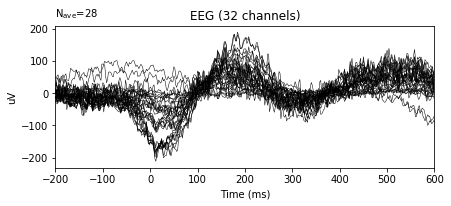

Band-Pass Filter


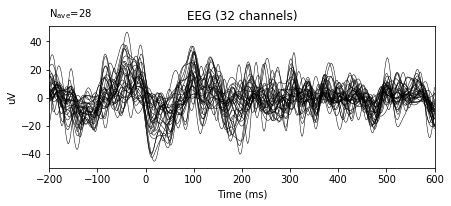

Topographic map - Band-Pass Filter


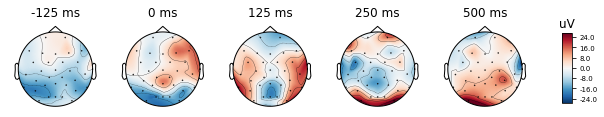

In [33]:
#A
# Low-Pass Filter
lp_raw = raw.copy().filter(l_freq=None,h_freq=33)
lp_epochs = Epochs(hp_raw, events, {'HandStart' : 1}, tmin=-0.2, tmax=0.6, proj=False,
                baseline=None, preload=True, 
                verbose =False)

avg_epochslp = lp_epochs.average()
print("Low-Pass Filter")
fig_lowpass = avg_epochslp.plot(time_unit='ms')

#Band-Pass filter
bp_raw = raw.copy().filter(l_freq=6,h_freq=33)
bp_epochs = Epochs(bp_raw, events, {'HandStart' : 1}, tmin=-0.2, tmax=0.6, proj=False,
                baseline=None, preload=True, 
                verbose =False)

avg_epochsbp = bp_epochs.average()
print("Band-Pass Filter")
fig_bandpass = avg_epochsbp.plot(time_unit='ms')

#B
# We should use Band-Pass Filter in order to improve the previous analysis. A lower cutoff frequency of 6 Hz and an upper cutoff frequency of 33 Hz could be effective in capturing both mu waves (8-13 Hz) and beta waves (13-30 Hz) associated with physical movement. 
# This range would cover the frequencies relevant for the analysis of movement-related brain activity...
print("Topographic map - Band-Pass Filter")
avg_epochsbp.plot_topomap([-0.125,0,0.125,0.250,0.5],time_unit='ms');



## Re-referencing EEG data

The values of the EEG signals are relative to a reference. Sometimes, experiments are performed to establish the most adequate electrode to be used as reference, or electrodes are set in specific localizations for this purpose. It is also possible to chose a virtual signal as reference, e.g., the average of all the signals or a subset of them.

Applying average reference.
Applying a custom EEG reference.
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


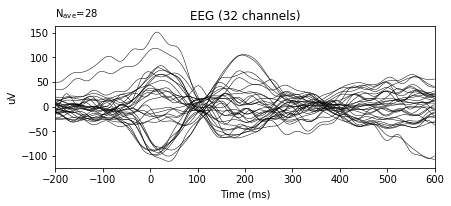

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


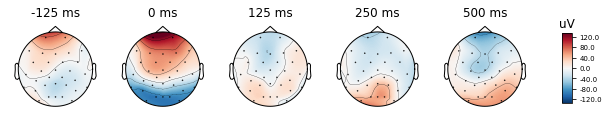

''

In [34]:
# function to change the reference of th EEG signals
_raw, _ = mne.io.set_eeg_reference(raw, ref_channels='average')
_raw = _raw.copy().filter(1,20)
epochs = Epochs(_raw, events, {'HandStart' : 1}, tmin=-0.2, tmax=0.6, proj=False,
                baseline=None, preload=True, 
                verbose =False)
avg_epochs = epochs.average()
avg_epochs.plot()
avg_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])
;

It is possible to use several electrodes as reference (ref_channels=['O1','F4']).
The 'Z' electrodes, placed on the midline saggital plane, are often used as reference.

Applying a custom EEG reference.
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


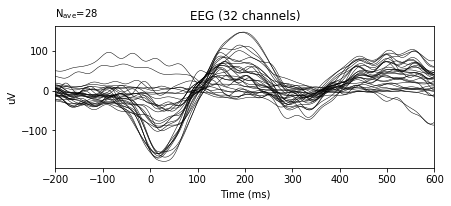

time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


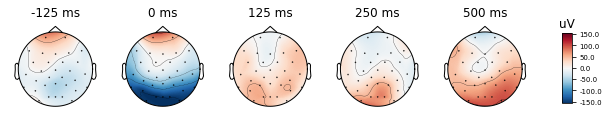

''

In [35]:
_raw, _ = mne.io.set_eeg_reference(raw,ref_channels=['Cz','Fz'])
_raw = _raw.copy().filter(1,20)
epochs = Epochs(_raw, events, {'HandStart' : 1}, tmin=-0.2, tmax=0.6, proj=False,
                baseline=None, preload=True, 
                verbose =False)
avg_epochs = epochs.average()
avg_epochs.plot()
avg_epochs.plot_topomap([-0.125,0,0.125,0.250,0.5])
;

## Motor tasks and sensorimotor rhythms

Motor tasks and their mental simulation (motor imagery) produce changes in the alpha (8-13Hz) and beta (13-30Hz) rhythms.

 -Event related desynchronization (ERD)
 
 -Event related synchronization (ERS)

This should happen at the sensorimotor cortex areas, where C3, Cz and C4 electrodes are typically placed.




Now, we segment the data around actions (events) that may change these sensorimotor rhythms. For each event two epochs are obtained: before/after, before/during, etc... So basically the data is divided into two classes.
Power Spectral Density can be used to analyze the differences between these two classes and try to identify changes in the alpha and beta rhythms.

For this example we use the event 'Replace'


In [36]:
# this code is used to compute the PSD
def get_psd_from_epochs(epochs, fmin, fmax):
    psds, freqs = mne.time_frequency.psd_welch(epochs, fmin, fmax)
    psds = 10 * np.log10(psds)
    psds_mean = psds.mean(0).mean(0)
    psds_std = psds.mean(0).std(0)
    return {'mean':psds_mean, 'std':psds_std, 'freq':freqs}

1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
28 events found
Event IDs: [1]
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


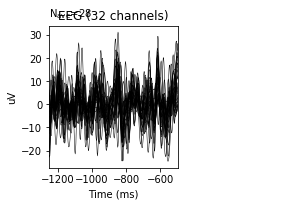

Effective window size : 0.512 (s)


In [42]:
raw = create_mne_raw_object_from_csv(fname)

picks = pick_types(raw.info, eeg=True) 
_raw = raw.copy().filter(7,35,picks=picks, method='iir')
events = find_events(_raw,stim_channel='Replace')
epochs = Epochs(_raw, events, {'Before' : 1}, -1.25, -0.5, picks=picks, proj=False,
                        baseline=None, preload=True,
                        verbose=False)
avg_epochs = epochs.average()
avg_epochs.plot()

data = get_psd_from_epochs(epochs, fmin=5, fmax=35)


time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


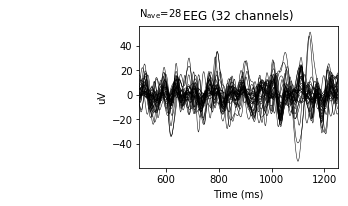

Effective window size : 0.512 (s)


In [43]:
epochs = Epochs(_raw, events, {'After' : 1}, 0.5, 1.25, picks=picks, proj=False,
                        baseline=None, preload=True,
                        verbose=False)
avg_epochs = epochs.average()
avg_epochs.plot()

data1 = get_psd_from_epochs(epochs, fmin=5, fmax=35)

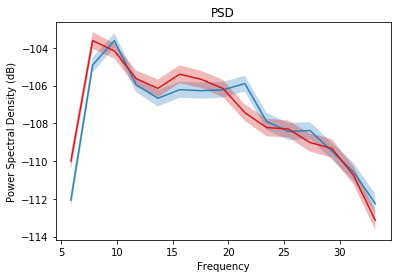

In [44]:

colors = ['#2b83ba','#d7191c','#fdae61','#fdae61', '#abdda4','#2b83ba']
plt.rcParams['axes.prop_cycle'] = cycler.cycler(color=colors)            
cgen = itertools.cycle(colors)

def plot_psds(data_list):
    fig, ax = plt.subplots()
    for data in data_list:
        ax.plot(data['freq'], data['mean'])
        ax.fill_between(data['freq'], data['mean'] - 0.1*data['std'], data['mean'] + 0.1*data['std'], alpha=.3)
    ax.set(title='PSD', xlabel='Frequency',
               ylabel='Power Spectral Density (dB)')
    plt.show()
        
plot_psds([data,data1])


## CSP

Common Spatial Patterns (CSP) is a supervised algorithm that can be applied in order to improve the distinction between both classes. CSP computes spatial filters that maximize the variance of one class while they minimize the variance of the other class. This eases the classification of the data with a subsequent classification algorithms. 

Ideally, all the subjects and series in the train dataset should be used, but this would require more computational time.


1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
34 events found
Event IDs: [1]
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


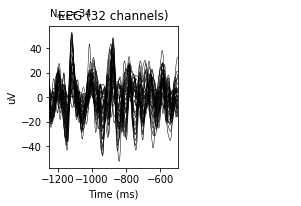

Effective window size : 0.512 (s)
34 events found
Event IDs: [1]
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


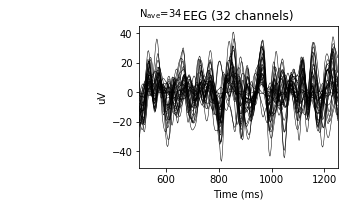

Effective window size : 0.512 (s)


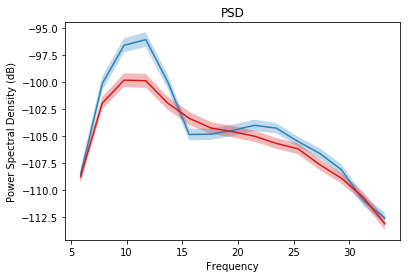

In [45]:
subject=2
serie=5
fname = './train/subj%d_series%d_data.csv' % (subject,serie)
raw = create_mne_raw_object_from_csv(fname)

picks = pick_types(raw.info, eeg=True) 
_raw = raw.copy().filter(7,35,picks=picks, method='iir')
events = find_events(_raw,stim_channel='Replace')

#picks = [raw.ch_names.index(ch) for ch in ['Cz', 'Pz', 'C3', 'C4']]
epochs = Epochs(_raw, events, {'Before' : 1}, -1.25, -0.5, picks=picks, proj=False,
                        baseline=None, preload=True,
                        verbose=False)

avg_epochs = epochs.average()
avg_epochs.plot()

psd_before = get_psd_from_epochs(epochs, fmin=5, fmax=35)

events = find_events(_raw,stim_channel='Replace')
epochs1 = Epochs(_raw, events, {'After' : 1}, 0.5, 1.25, picks=picks, proj=False,
                        baseline=None, preload=True,
                        verbose=False)
avg_epochs = epochs1.average()
avg_epochs.plot()

psd_after = get_psd_from_epochs(epochs1, fmin=5, fmax=35)

plot_psds([psd_before,psd_after])

CSP

This is a supervised algorithm and, therefore, it requires the use of annotated data for the training phase.

Label 1 is used for epochs before the event and label 0 for epochs after the event.



Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


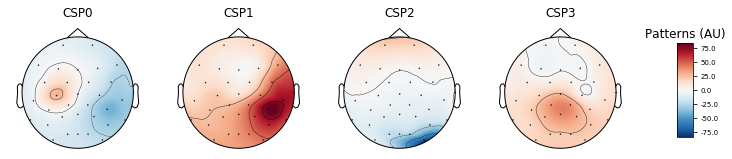

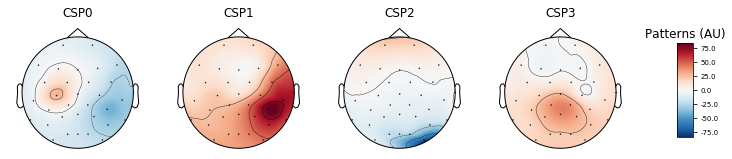

In [46]:
#CSP
#concatenate all epochs (X) and set labels (y).
y = [1]*len(epochs) + [0]*len(epochs1)

# get data 
X = np.concatenate((epochs.get_data(),epochs1.get_data()))
y = np.array(y)

# run CSP
csp = CSP()
csp.fit(X,y)

csp.plot_patterns(epochs.info,  ch_type='eeg',
                  units='Patterns (AU)', size=1.5)

CSP computes several filters that can be applied to the signals. This results in different spatial patterns detected in the data. 

The code below serves to visualize the spatial pattern for the first filter and to compute the PSD when that pattern is applied to the data.

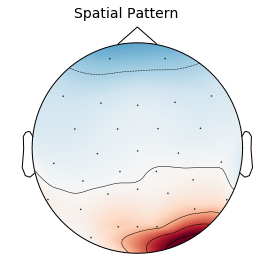

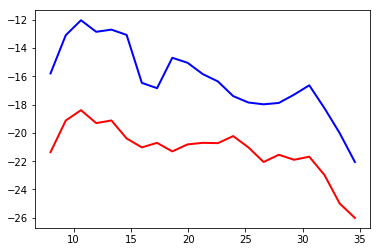

In [47]:
n_pattern=2

# compute spatial filtered spectrum
# The code is different because here PSD is computed from numpy arrays, 
# instead of the objects in the MNE package
po = []
for x in X:
    f,p = welch(np.dot(csp.filters_[n_pattern,:].T,x), 500, nperseg=512)
    po.append(p)
po = np.array(po)


# plot first pattern
pattern = csp.patterns_[n_pattern,:]
pattern -= pattern.mean()
ix = np.argmax(abs(pattern))
# the parttern is sign invariant.
# invert it for display purpose
if pattern[ix]>0:
    sign = 1.0
else:
    sign = -1.0

fig, ax_topo = plt.subplots(1, 1, figsize=(12, 4))
title = 'Spatial Pattern'
fig.suptitle(title, fontsize=14)
img, _ = plot_topomap(sign*pattern,epochs.info,axes=ax_topo) #,show=False)

#plt.colorbar(img, cax=ax_colorbar)

# plot spectrum
fix = (f>7) & (f<35)


fig, ax = plt.subplots()
plt.plot(f[fix],10*np.log10(po[y==1][:,fix].mean(axis=0).T),'-r',lw=2)
plt.plot(f[fix],10*np.log10(po[y==0][:,fix].mean(axis=0).T),'-b',lw=2)
plt.show()

## Classification

In [48]:
# Classification using LDA and CSP
lda = LinearDiscriminantAnalysis() #Classification algorithm (supervised)
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False) #Signal processing algorithm (supervised)

# Use scikit-learn Pipeline
clf = Pipeline([('CSP', csp), ('LDA', lda)])

#We use a fixed train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
clf.fit(x_train, y_train)

test_score = clf.score(x_test, y_test)
print('Test accuracy: ',test_score)

train_score = clf.score(x_train, y_train)
print('Train accuracy: ',train_score)


# Accuracy by chance
class_balance = np.mean(y_test == y_test[0])
class_balance = max(class_balance, 1. - class_balance)
print('Classification accuracy by chance: ' + str(class_balance))

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Test accuracy:  0.9411764705882353
Train accuracy:  1.0
Classification accuracy by chance: 0.5882352941176471


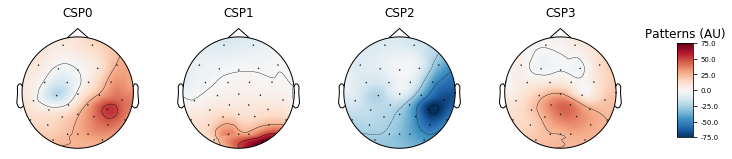

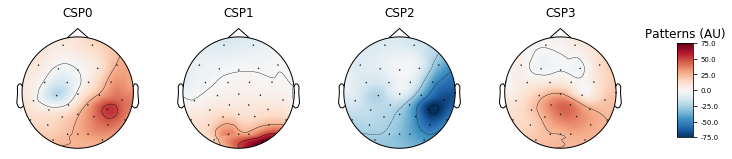

In [49]:

csp.plot_patterns(epochs.info,  ch_type='eeg',
                  units='Patterns (AU)', size=1.5)

For subject 2.
    
A) We perform the same CSP analysis with the event 'HandStart' instead of 'Replace'. In this case there is a class with no movement (before the event) and a class with movement (after the event).

B) We perform the classification of the signal using the same "pipeline" that we have used before (CSP and LDA). Additionally, measure the peformance (score) when the classification is trained and evaluated on different subjects.

1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
34 events found
Event IDs: [1]


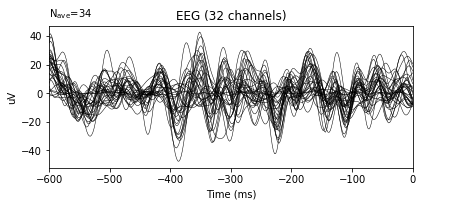

Effective window size : 0.512 (s)
34 events found
Event IDs: [1]


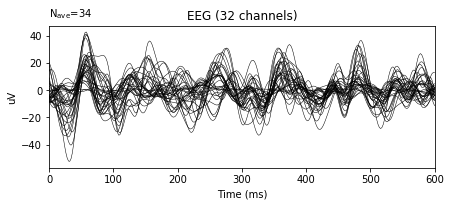

Effective window size : 0.512 (s)


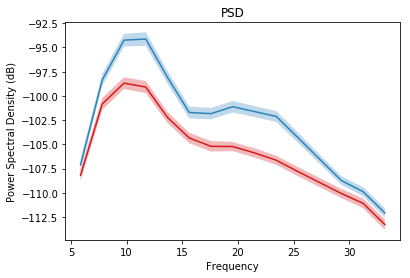

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.


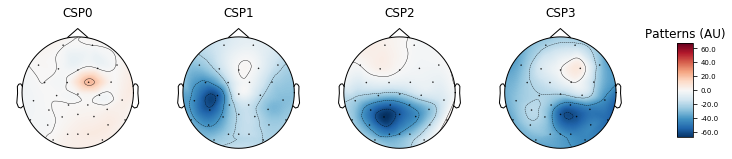

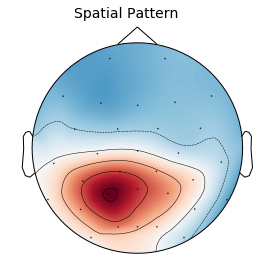

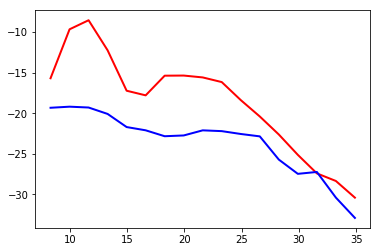

In [67]:
#A
subject=2
serie=5
fname = './train/subj%d_series%d_data.csv' % (subject,serie)
raw = create_mne_raw_object_from_csv(fname)

picks = pick_types(raw.info, eeg=True) 
_raw = raw.copy().filter(7,35,picks=picks, method='iir')
events = find_events(_raw,stim_channel='HandStart')
epochs = Epochs(_raw, events, {'Before' : 1}, -0.6, 0, picks=picks, proj=False, #From 0.6sec before the event
                        baseline=None, preload=True,
                        verbose=False)

avg_epochs = epochs.average()
avg_epochs.plot(time_unit='ms')
psd_before = get_psd_from_epochs(epochs, fmin=5, fmax=35)
events = find_events(_raw,stim_channel='HandStart')
epochs1 = Epochs(_raw, events, {'After' : 1}, 0, 0.6, picks=picks, proj=False, #To 0.6sec after the event
                        baseline=None, preload=True,
                        verbose=False)

avg_epochs = epochs1.average()
avg_epochs.plot(time_unit='ms')
psd_after = get_psd_from_epochs(epochs1, fmin=5, fmax=35)
plot_psds([psd_before,psd_after])

#CSP
#concatenate all epochs (X) and set labels (y).
y = [1]*len(epochs) + [0]*len(epochs1)

#get data 
X = np.concatenate((epochs.get_data(),epochs1.get_data()))
y = np.array(y)

# run CSP
csp = CSP()
csp.fit(X,y)

csp.plot_patterns(epochs.info,  ch_type='eeg',
                  units='Patterns (AU)', size=1.5)

n_pattern=2
po = []
for x in X:
    f,p = welch(np.dot(csp.filters_[n_pattern,:].T,x), 500, nperseg=512)
    po.append(p)
po = np.array(po)


# plot first pattern
pattern = csp.patterns_[n_pattern,:]
pattern -= pattern.mean()
ix = np.argmax(abs(pattern))
# the parttern is sign invariant.
# invert it for display purpose
if pattern[ix]>0:
    sign = 1.0
else:
    sign = -1.0

fig, ax_topo = plt.subplots(1, 1, figsize=(12, 4))
title = 'Spatial Pattern'
fig.suptitle(title, fontsize=14)
img, _ = plot_topomap(sign*pattern,epochs.info,axes=ax_topo)
# plot spectrum
fix = (f>7) & (f<35)
fig, ax = plt.subplots()
plt.plot(f[fix],10*np.log10(po[y==1][:,fix].mean(axis=0).T),'-r',lw=2)
plt.plot(f[fix],10*np.log10(po[y==0][:,fix].mean(axis=0).T),'-b',lw=2)
plt.show()

In [68]:
#B
# Classification using LDA and CSP
lda = LinearDiscriminantAnalysis() #Classification algorithm (supervised)
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False) #Signal processing algorithm (supervised)

# Use scikit-learn Pipeline
clf = Pipeline([('CSP', csp), ('LDA', lda)])
# We use a fixed train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
clf.fit(x_train, y_train)
print("SUBJECT 2 - RESULTS")
test_score = clf.score(x_test, y_test)
print('Test accuracy: ', round(test_score,2))
train_score = clf.score(x_train, y_train)
print('Train accuracy: ',round(train_score,2))
# Accuracy by chance
class_balance = np.mean(y_test == y_test[0])
class_balance = max(class_balance, 1. - class_balance)
print(f'Classification accuracy by chance: {round(class_balance,2)}\n')

#SUBJECT 1
subject= 1
serie= 5
fname = './train/subj%d_series%d_data.csv' % (subject,serie)
raw = create_mne_raw_object_from_csv(fname)

picks = pick_types(raw.info, eeg=True) 
_raw = raw.copy().filter(7,35,picks=picks, method='iir')
events = find_events(_raw,stim_channel='HandStart')
epochs = Epochs(_raw, events, {'Before' : 1}, -0.6, 0, picks=picks, proj=False, #From 0.6sec before the event
                        baseline=None, preload=True,
                        verbose=False)

events = find_events(_raw,stim_channel='HandStart')
epochs1 = Epochs(_raw, events, {'After' : 1}, 0, 0.6, picks=picks, proj=False, #To 0.6sec after the event
                        baseline=None, preload=True,
                        verbose=False)


#CSP
#concatenate all epochs (X) and set labels (y).
y = [1]*len(epochs) + [0]*len(epochs1)

#get data 
X = np.concatenate((epochs.get_data(),epochs1.get_data()))
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
clf.fit(x_train, y_train)
print("\nSUBJECT 1 - RESULTS")
test_score = clf.score(x_test, y_test)
print('Test accuracy: ', round(test_score,2))
train_score = clf.score(x_train, y_train)
print('Train accuracy: ', round(train_score,2))
# Accuracy by chance
class_balance = np.mean(y_test == y_test[0])
class_balance = max(class_balance, 1. - class_balance)
print(f'Classification accuracy by chance: {round(class_balance,2)}\n')


#There are no significant differences between the two subjects.

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
SUBJECT 2 - RESULTS
Test accuracy:  0.82
Train accuracy:  0.96
Classification accuracy by chance: 0.59

1 channel names are too long, have been truncated to 15 characters:
['BothStartLoadPhase']
28 events found
Event IDs: [1]
28 events found
Event IDs: [1]
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.

SUBJECT 1 - RESULTS
Test accuracy:  0.86
Train accuracy:  1.0
Classification accuracy by chance: 0.57



In [69]:
# Monte-carlo cross-validation:
cv = ShuffleSplit(10, test_size=0.25, random_state=42)
cv_split = cv.split(X)


scores = cross_val_score(clf, X, y, cv=cv, n_jobs=1)

print(f'Mean: {round(scores.mean(),2)} ± {round(scores.std(),2)} std')

Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Mean: 0.86 ± 0.08 std
